# <font color=black> Time-series features </font>
<hr style="border:1px solid black">

## <font color=#B14263> Imports

In [19]:
import sys,json, os, glob
import pandas as pd
import numpy as np
import nibabel as nib
from scipy.stats import spearmanr

main_dir='/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project/'
sys.path.append(main_dir+'/code/')

from connectivity.ts_features import FeatureSets
from connectivity.seed_to_target import Seed2target
#statistics
#import statsmodels.api as sm
#from sklearn.preprocessing import LabelEncoder
from brsc_statistics import Statistics 
from sim_matrix import Matrix
from statsmodels.stats.multitest import multipletests

#plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from plotting import Plotting
import seaborn as sns


config_file=main_dir + '/config/analyses/brsc_functional.json'

%matplotlib inline
%load_ext autoreload
%autoreload 2

### load config file
with open(config_file) as config_f:
    config = json.load(config_f) # load config info
stat_func=Statistics(config=config,ana_dir="",analysis="")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<hr style="border:1px solid black">

## <font color=#B14263> A. Spinal cord time series features 
##### Initialize the analysis and load the timeseries

In [9]:
IDs=config["participants_IDs_ALL"]
structure="spinalcord"
ts_features=FeatureSets(config,IDs=IDs,structure=structure)
seed2seed=Seed2target(config_file,IDs=IDs,ana="ts_features",seed_kind="atlas",structure=[structure],verbose=0) # initialize the function


Feature analyses output directory: /cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/features/sc_oct25/spinalcord//

Analyzing 67 participant(s)



#### <font color=#B14263> A.2 Timeseries extraction
So far the timeseries are extracted in the seed2seed function but it could be implement later in the feature function

In [10]:
timeseries,timeseries_labels,labels_list=seed2seed.extract_atlas_data(standardize=False,redo=False,n_jobs=2)

The timeseries were already extracted, loading them ...


#### <font color=#B14263> A.3 Compute features calculation

In [11]:
#load alff in incorporate in the feature:
alff_dir=config["project_dir"] + "/figures/f02_functional_sc/alff_inPAM50_nostd_oct25/spinalcord/alff/slow5/1_first_level/metric/"
alff_df=[];alff=[]
for ID_nb, ID in enumerate(IDs):
    alff_file= glob.glob(alff_dir + "/sub-" + ID + "_alff_levels.csv")[0]
    alff_df.append(pd.read_csv(alff_file))
    alff.append(np.array(alff_df[ID_nb]["alff"]))

df_features,df_features_z=ts_features.compute_pychatch24(ts_data=timeseries['spinalcord']['zmean'],
                               seed_labels=labels_list,add_features={"alff": alff},scaling_method="robust_sigmoid",#scaling_method="robust_sigmoid",
                                                         redo=False)
df_features["rois_couple"]=df_features["ventro_dorsal"] + "_" + df_features["right_left"]
df_features_z["rois_couple"]=df_features_z["ventro_dorsal"] + "_" + df_features_z["right_left"]

#### <font color=#B14263> A.4 Compute similarity matrices

/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/features/sc_oct25/spinalcord/1_first_level/sim_matrix/sim_matrix_df.csv


/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project//code/sim_matrix.py:126: RuntimeWarning: Mean of empty slice
  mean_sim_matrix = np.nanmean(np.stack(all_sim_matrix), axis=0)


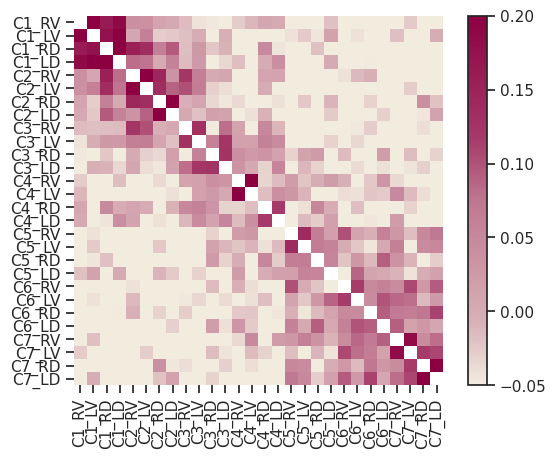

In [24]:
# --- Compute similarity
atlas_labels=['C1_RV', 'C1_LV', 'C1_RD','C1_LD','C2_RV', 'C2_LV', 'C2_RD','C2_LD', 'C3_RV', 'C3_LV', 'C3_RD', 'C3_LD', 'C4_RV', 'C4_LV','C4_RD', 'C4_LD', 'C5_RV', 'C5_LV', 'C5_RD', 'C5_LD', 'C6_RV','C6_LV', 'C6_RD', 'C6_LD', 'C7_RV', 'C7_LV', 'C7_RD', 'C7_LD']
output_dir= config["project_dir"] +config["ts_features"]["analysis_dir"][structure]
ana_matrix=Matrix(config=config,IDs=IDs,output_dir=output_dir)
selected_cols = np.r_[8:11,12:17,18,21:33]
selected_cols = np.r_[8:11,12:17,18,21:24,25:33]

col_selected = df_features_z.columns[selected_cols]
all_sim_matrix, mean_sim_matrix,df_sim=ana_matrix.compute_similarity_matrix(data_df=df_features_z,column_labels=col_selected ,atlas_labels=atlas_labels,
                                                                            scaling_method="robust_sigmoid",redo=False)

# --- Plot the matrix
colors = ["#F2ECDF","#D9B1B8","#CC94A4","#BF7690","#A63B69","#991E55","#8C0041"]  # green
plot=Plotting(config_file,"")
custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

plot.plot_heatmap(matrix=mean_sim_matrix,
                  vmax=0.2,vmin=-0.05,
                  cmap=custom_cmap,
            xticklabels=labels_list,yticklabels=labels_list,
                    labels=labels_list,
                  output_f=output_dir + '/figures/feature_matrix.pdf',
                  save=False)
plt.show()

In [27]:
from scipy import stats
mean_betwith=df_sim.groupby(["IDs","age","sex","betwith_labels"], sort=False)[["sim"]].mean().reset_index()
# ---- compute within versus between t-test
t_test=stats.ttest_rel(mean_betwith[mean_betwith["betwith_labels"]=="intra"]["sim"],mean_betwith[mean_betwith["betwith_labels"]=="inter"]["sim"])
print("t(" + str(t_test.df) + "): " + str(np.round(t_test.statistic,2)) + " p-value: " + str(t_test.pvalue))

plot.boxplots(df=mean_betwith,
              x_data="betwith_labels",x_order=["intra","inter"],
                  indiv_values=True,#invers_axes=True,
                  palette=["#8C0041","#CC94A4"],
              height=2,aspect=0.25,
                  y_data="sim",
              ymin=-0.1, ymax=0.4,
              output_dir=output_dir + "/figures/",
              output_tag="sim_intra-inter",
              save=False)
plt.show()

t(66): 15.57 p-value: 8.661985734456709e-24
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/features/sc_oct25/spinalcord//figures/sim_intra-inter.pdf


/export02/data/landelle/anaconda/envs/CL_brsc_aging_env_py10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/export02/data/landelle/anaconda/envs/CL_brsc_aging_env_py10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<hr style="border:1px solid black">

## <font color=#B14263> D. Age and sex effects

### Features vs age Statistics

In [20]:
df_reduced = df_features.groupby(['IDs', 'age', 'sex', 'groups',"rois","rois_couple"], as_index=False)[col_selected].mean()
df_mean_metrics={};
mean_results = [];roi_results=[];signif_feature=[]

for metric_nb, sub_metric in enumerate(col_selected): 
    df_mean_metrics[sub_metric]={}
    signed_r2, p_age,p_sex, beta_age, beta_sex, stat_age,stat_sex=stat_func.signed_partial_r2(df=df_reduced.dropna(),y=sub_metric,predictor="age",covariates=["sex"],random='IDs')
    mean_results.append({"sub_metric": sub_metric,"signed_r2": signed_r2,"p_age": p_age,"beta_age": beta_age,"beta_sex": beta_sex,"tvalue_age": stat_age,"tvalue_sex": stat_sex})
    
    for roi in np.unique(df_reduced["rois_couple"]):
        df_roi_metrics=df_reduced[df_reduced["rois_couple"]==roi]
        signed_r2_2, p_age2,p_sex2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y=sub_metric,predictor="age",covariates=["sex"],random="IDs")
        if p_age2<0.05:
            signif_feature.append(sub_metric)
            print(sub_metric +" " + roi + " p_age:" + str(p_age2))
        roi_results.append({"sub_metric": sub_metric,"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"p_sex": p_sex2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
        

mean_result_df= pd.DataFrame(mean_results)  
roi_results_df= pd.DataFrame(roi_results)

print(" ")
for roi in np.unique(df_reduced["rois_couple"]):
    print(roi + " absolute mean t-value: " + str(np.round(np.mean(np.abs(roi_results_df[(roi_results_df["rois"]==roi)]["tvalue_age"])),3)))

# ---- FDR correction
p_age = roi_results_df["p_age"].values; p_sex = roi_results_df["p_sex"].values
reject, page_corrected, _, _ = multipletests(p_age, method='fdr_bh'); reject, psex_corrected, _, _ = multipletests(p_sex, method='fdr_bh')
roi_results_df["page_fdr"] = page_corrected; roi_results_df["psex_fdr"] = psex_corrected


acf_timescale dorsal_left p_age:0.001821096980080758
embedding_dist dorsal_left p_age:0.038339803910615394
embedding_dist ventral_right p_age:0.04383768445326141
centroid_freq dorsal_left p_age:0.0008458167395168964
entropy_pairs dorsal_left p_age:0.026779284651260577
low_freq_power dorsal_left p_age:0.0032423499106760787
forecast_error dorsal_left p_age:0.002223160500687742
forecast_error dorsal_right p_age:0.03880857137470561
forecast_error ventral_right p_age:0.017115093884954424
SD dorsal_left p_age:0.00020506985272506067
SD dorsal_right p_age:0.0013478292778041842
SD ventral_left p_age:0.03478964775996723
alff dorsal_left p_age:0.0037218943085418487
alff dorsal_right p_age:0.007067230612505268
 
dorsal_left absolute mean t-value: 1.513
dorsal_right absolute mean t-value: 1.132
ventral_left absolute mean t-value: 0.921
ventral_right absolute mean t-value: 1.016


/export02/data/tmp/ipykernel_2467052/618310863.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


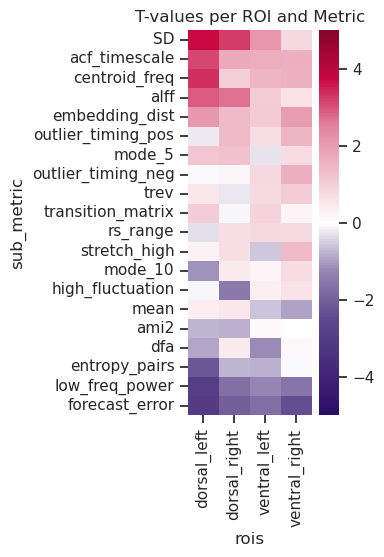

In [28]:
import seaborn as sns
pivot = roi_results_df.pivot(index="sub_metric", columns="rois", values="tvalue_age")
#feat_order=["MTR","T2s_vx_gm","T2s_vx_wm","FA","RD","AD","MD"]
colors = ["#2A0C66","#452B7A","#60498D","#9586B3","#FFFFFF","#F1C2CF","#E3849F","#C7093F","#850429"]  # blue → white → red
feat_order = pivot.mean(axis=1).sort_values(ascending=False).index.tolist()
custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
pivot = pivot.reindex(index=feat_order)

plt.figure(figsize=(2, 5))
sns.heatmap(pivot, cmap=custom_cmap, center=0, vmin=-5, vmax=5, fmt=".2f")
plt.title("T-values per ROI and Metric")
plt.tight_layout()
plt.savefig(output_dir + '/figures/age_effect_tvalues_quad.pdf', format='pdf')
plt.show()   


/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/features/sc_oct25/spinalcord/1_first_level/sim_matrix/sim_matrix_df_signif_age.csv


/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2025_brsc_aging_project//code/sim_matrix.py:126: RuntimeWarning: Mean of empty slice
  mean_sim_matrix = np.nanmean(np.stack(all_sim_matrix), axis=0)


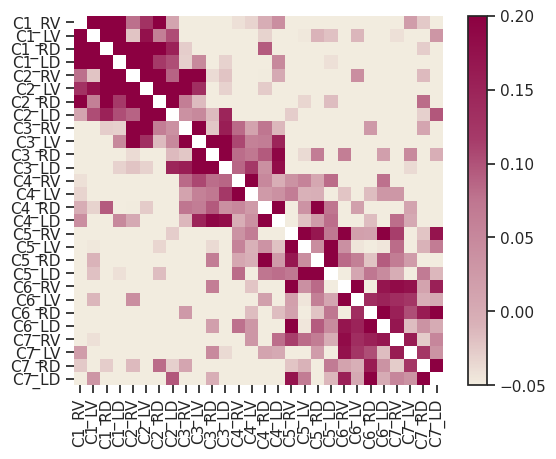

In [29]:
# --- Compute similarity
atlas_labels=['C1_RV', 'C1_LV', 'C1_RD','C1_LD','C2_RV', 'C2_LV', 'C2_RD','C2_LD', 'C3_RV', 'C3_LV', 'C3_RD', 'C3_LD', 'C4_RV', 'C4_LV','C4_RD', 'C4_LD', 'C5_RV', 'C5_LV', 'C5_RD', 'C5_LD', 'C6_RV','C6_LV', 'C6_RD', 'C6_LD', 'C7_RV', 'C7_LV', 'C7_RD', 'C7_LD']
output_dir= config["project_dir"] +config["ts_features"]["analysis_dir"][structure]
ana_matrix=Matrix(config=config,IDs=IDs,output_dir=output_dir)

selected_feat=np.unique(signif_feature)
all_sim_matrix_age, mean_sim_matrix_age,df_sim_age=ana_matrix.compute_similarity_matrix(data_df=df_features_z,column_labels=selected_feat ,atlas_labels=atlas_labels,tag="_signif_age",
                                                                            scaling_method="robust_sigmoid",redo=True)

# --- Plot the matrix
colors = ["#F2ECDF","#D9B1B8","#CC94A4","#BF7690","#A63B69","#991E55","#8C0041"]  # green
plot=Plotting(config_file,"")
custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

plot.plot_heatmap(matrix=mean_sim_matrix_age,
                  vmax=0.2,vmin=-0.05,
                  cmap=custom_cmap,
            xticklabels=labels_list,yticklabels=labels_list,
                    labels=labels_list,
                  output_f=output_dir + '/figures/feature_matrix_sim_matrix_df_signif_age.pdf',
                  save=True)
plt.show()

<hr style="border:1px solid black">

### <font color=#B14263> B. FC and feature coupling

In [38]:
temp_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/figures/f02_functional_sc/features/sc_4June25/spinalcord/1_first_level/sim_matrix/"
fc_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/figures/f02_functional_sc/seed2seed_nostd/spinalcord/"
population_info=config["main_dir"]  + "/2024_brsc_aging_project/config/participants_brsc_aging.tsv"
metadata = pd.read_csv(population_info, delimiter='\t')
temp_matrix_df=temp_dir + "sim_matrix.csv"

temp_f_age=[];temp_f=[];temp_matrix=[];temp_matrix_age=[];fc_f=[];fc_matrix=[];age=[];sex=[]
for ID_nb, ID in enumerate(IDs):
    temp_f.append(glob.glob(temp_dir + "sub-"+ID+"_sim_matrix.csv")[0])
    temp_f_age.append(glob.glob(temp_dir + "sub-"+ID+"_sim_matrix_signif_age.csv")[0])
    temp_matrix.append(np.array(pd.read_csv(temp_f[ID_nb],header=None)))
    temp_matrix_age.append(np.array(pd.read_csv(temp_f_age[ID_nb],header=None)))
    fc_f.append(glob.glob(fc_dir + "/1_first_level/correlation/sub-"+ID+"*_corr_matrix*.csv")[0])
    fc_matrix.append(np.array(pd.read_csv(fc_f[ID_nb],header=None)))
    age.append(metadata[metadata["participant_id"] == ID]["age"].values[0])
    sex.append(metadata[metadata["participant_id"] == ID]["sex"].values[0])

temp_matrix=np.array(temp_matrix);temp_matrix_age=np.array(temp_matrix_age);fc_matrix=np.array(fc_matrix)

# load grouped df
temp_df=pd.read_csv(glob.glob(temp_dir + "sim_matrix_df.csv")[0])
temp_df_age=pd.read_csv(glob.glob(temp_dir + "sim_matrix_df_signif_age.csv")[0])

fc_df=pd.read_csv(glob.glob(fc_dir + "/2_second_level/correlation/n67_corr_concat_df_ALL_C1C7_quad_z_half.csv")[0])
all_df=temp_df;all_df["fc"]=fc_df["fcorr"]; all_df_age=temp_df_age;all_df_age["fc"]=fc_df["fcorr"]

all_df["rois"] = all_df["seed1"] + "_" + all_df["seed2"];all_df_age["rois"] = all_df_age["seed1"] + "_" + all_df_age["seed2"]

/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project//code/brsc_statistics.py:111: RuntimeWarning: Mean of empty slice
  m1_all = np.stack(matrix1); m1_mean=np.nanmean(m1_all,axis=0)
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project//code/brsc_statistics.py:112: RuntimeWarning: Mean of empty slice
  m2_all = np.stack(matrix2); m2_mean=np.nanmean(m2_all,axis=0)


0.582070578192968
9.140678400286055e-70


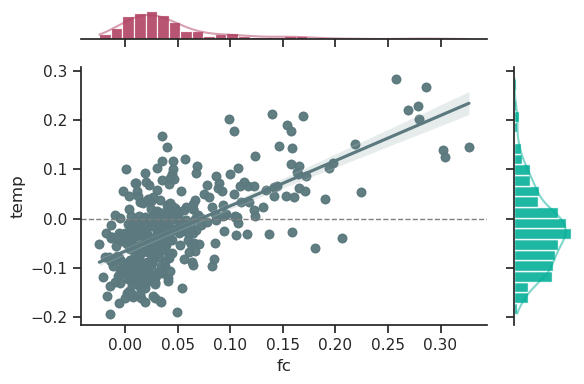

In [39]:
from scipy.stats import spearmanr
df_fc_temp,data_fc_temp=stat_func.compute_regional_coupling(matrix1=fc_matrix[:, :, :],matrix2=temp_matrix[:, :, :],metrics=["fc","temp"],df_out=True,metadata_df=metadata)
r_value, p_value = spearmanr(data_fc_temp['fc'], data_fc_temp["temp"])
print(r_value); print(p_value)

plot.regplots(df=data_fc_temp,x_data="fc",y_data="temp",reg_color="#5b797e",x_color="#B14263",y_color="#04AF98",
             save=False,height=6,aspect=4,
              output_f=output_dir + '/figures/coupling_temp_fc')




In [41]:
roi_results_fc=[];roi_results_sim=[]
temp_df
for roi in all_df["rois"].unique():
    df_roi_metrics=all_df[all_df["rois"]==roi]
    signed_r2_2, p_age2,p_sex2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y="fc",predictor="age",covariates=["sex"])
    roi_results_fc.append({"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
    
    signed_r2_2, p_age2,p_sex2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y="sim",predictor="age",covariates=["sex"])
    roi_results_sim.append({"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
    
    roi_results_fc_df= pd.DataFrame(roi_results_fc)
    roi_results_sim_df= pd.DataFrame(roi_results_sim)


0.1488800527104594
0.003717869580346148


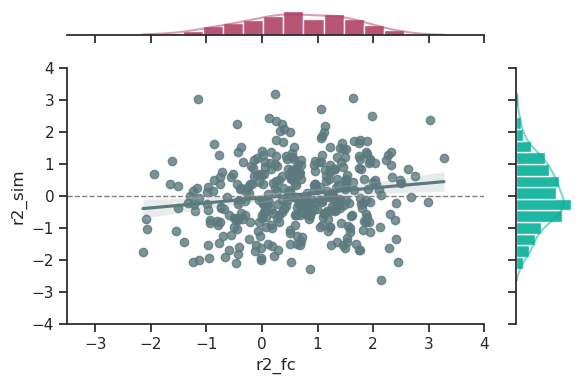

In [42]:
all_age_eff=pd.DataFrame({"rois":roi_results_fc_df["rois"],
            "r2_fc":roi_results_fc_df["tvalue_age"],
            "r2_sim":roi_results_sim_df["tvalue_age"]})


r_value, p_value = spearmanr(all_age_eff["r2_fc"], all_age_eff["r2_sim"])
print(r_value); print(p_value)

plot.regplots(df=all_age_eff,x_data="r2_fc",y_data="r2_sim",reg_color="#5b797e",x_color="#B14263",y_color="#04AF98"
              ,ymin=-4, ymax=4,xmin=-3.5, xmax=4,height=6,aspect=4,
              save=False,
              output_f=output_dir + '/figures/coupling_temp_fc_age')

